In [1]:
from sched import scheduler

import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import alpha
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [2]:
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import sophius.utils as utils
import sophius.dataload as dload
from sophius.modelgen import ConvModelGenerator
from sophius.train import train_express_gpu
import torchvision.datasets as dset
import torchvision.transforms as T
from sophius.encode import Encoder


VAL_SIZE = 1024

cifar10 = dset.CIFAR10('../data/CIFAR10', train=True, download=True, transform=T.ToTensor())
cifar_gpu = dload.cifar_to_gpu(cifar10)
loader_gpu = dload.get_loader_gpu(cifar_gpu, val_size=VAL_SIZE, batch_size=1024)

encoder = Encoder()

C:\Users\korol\miniforge3\envs\sophius\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified


In [3]:
model_gen = ConvModelGenerator((3, 32, 32), 10, conv_num=6, lin_num=3)

model_tmpl = model_gen.generate_model_tmpl()
model = model_tmpl.instantiate_model(gpu=True)

In [4]:
model

Sequential(
  (0): Conv2d(3, 8, kernel_size=(7, 7), stride=(3, 3))
  (1): LeakyReLU(negative_slope=0.001)
  (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (4): Conv2d(8, 16, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
  (5): ReLU()
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): AvgPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))
  (8): PReLU(num_parameters=16)
  (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=64, out_features=10, bias=True)
)

In [5]:
import sqlite3
import pandas as pd
import numpy as np
from sophius.encode import Encoder
encoder = Encoder()


with sqlite3.connect('../data/models.db') as conn:
    df = pd.read_sql('SELECT * FROM conv_10_lin_3_epoch_50', conn)
    df.sort_values(by='val_acc', ascending=False, inplace=True)
    df['log_params'] = np.log(df.params)
    df['log_flops'] = np.log(df.flops)
    df['log_time'] = np.log(df.time)

df[['val_acc', 'train_acc', 'log_params', 'log_flops', 'time']]

,val_acc,train_acc,log_params,log_flops,time
930,0.813477,0.994141,14.510533,20.684248,613.818239
302,0.787109,0.976562,13.622154,19.434304,258.427490
23,0.755859,0.996094,13.950680,17.706217,177.061507
763,0.752930,0.877930,13.238693,19.176300,282.491944
310,0.726562,0.918945,15.529769,16.338889,13.457602
...,...,...,...,...,...
208,0.195312,0.284180,16.191531,16.894167,164.906045
129,0.192383,0.167969,12.106446,13.014047,16.418530
115,0.176758,0.184570,11.432268,15.379271,29.879237
408,0.169922,0.196289,12.060596,12.907248,15.385370


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [7]:
def plot_corr(x, y):
    sns.jointplot(x=x, y=y, kind='reg')
    r2 = np.corrcoef(df.log_flops, df.log_time)[0, 1]**2
    plt.legend([f'r2 {r2:.4f}'])

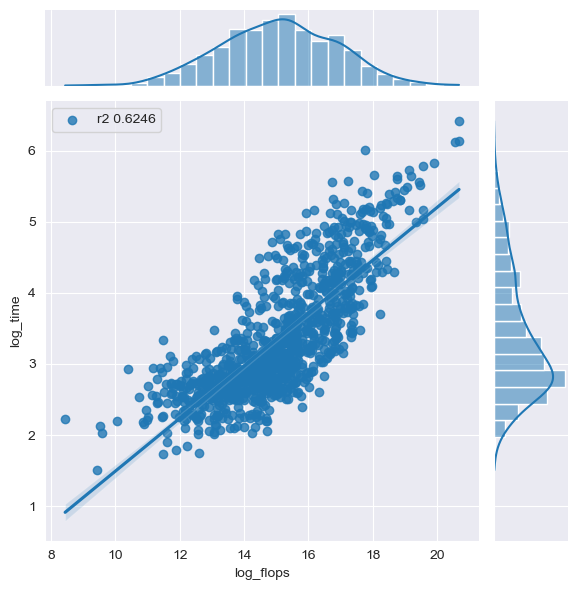

In [8]:
plot_corr(df.log_flops, df.log_time)

In [9]:
model_id = 310
t = encoder.hash2model(df.loc[model_id, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)         
model = t.instantiate_model(gpu=True)
model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2))
  (1): LeakyReLU(negative_slope=0.1)
  (2): AvgPool2d(kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=5408, out_features=1024, bias=True)
  (5): LeakyReLU(negative_slope=0.001)
  (6): Dropout(p=0.75, inplace=False)
  (7): Linear(in_features=1024, out_features=10, bias=True)
)

In [10]:
from sophius.train import train_on_gpu

# Explore val_size and batch_size

Loss 36.341: 100%|██████████| 50/50 [02:25<00:00,  2.91s/it] 


val_acc: 0.616 train_acc: 0.967


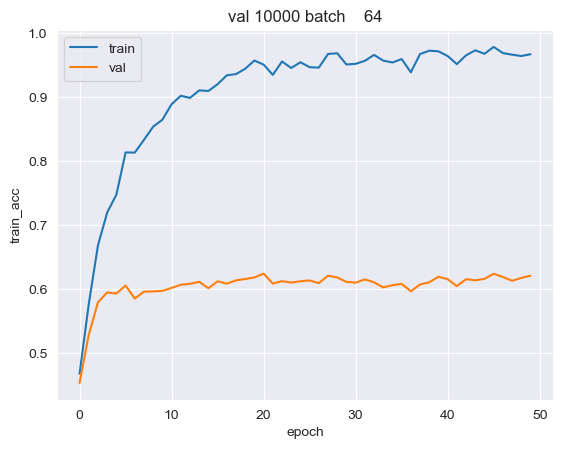

In [11]:
val_size = 10000
batch_size = 64

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 15.943: 100%|██████████| 50/50 [01:11<00:00,  1.42s/it] 


val_acc: 0.621 train_acc: 0.968


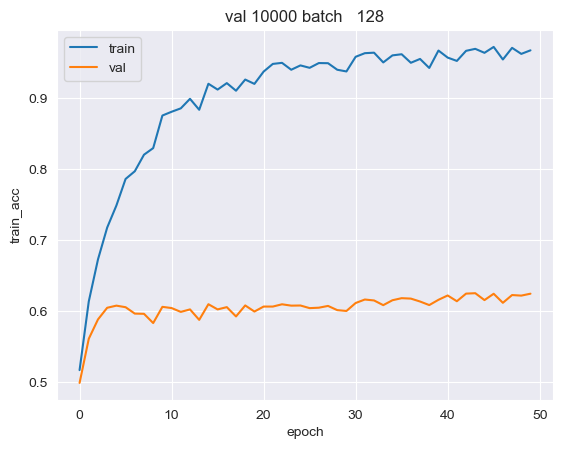

In [12]:
val_size = 10000
batch_size = 128

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [],
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 6.447: 100%|██████████| 50/50 [00:40<00:00,  1.23it/s] 


val_acc: 0.601 train_acc: 0.969


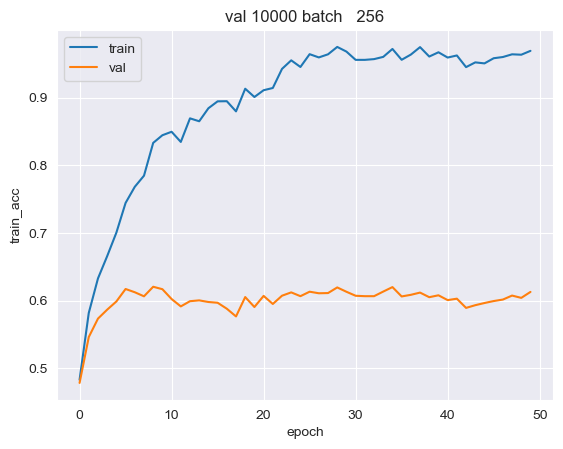

In [13]:
val_size = 10000
batch_size = 256

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [],
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 0.227: 100%|██████████| 50/50 [00:27<00:00,  1.85it/s] 


val_acc: 0.636 train_acc: 0.997


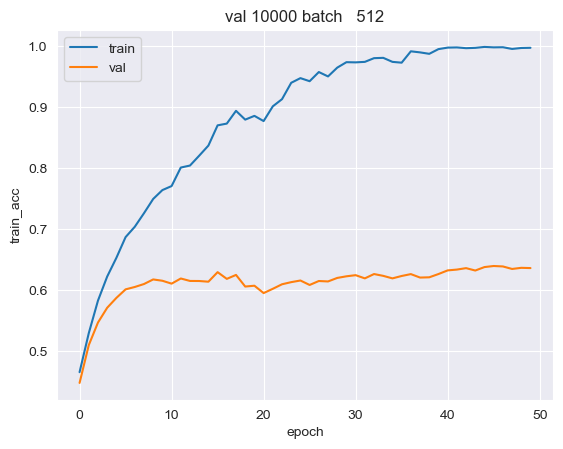

In [14]:
val_size = 10000
batch_size = 512

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [],
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 4.179: 100%|██████████| 50/50 [00:22<00:00,  2.22it/s] 


val_acc: 0.610 train_acc: 0.969


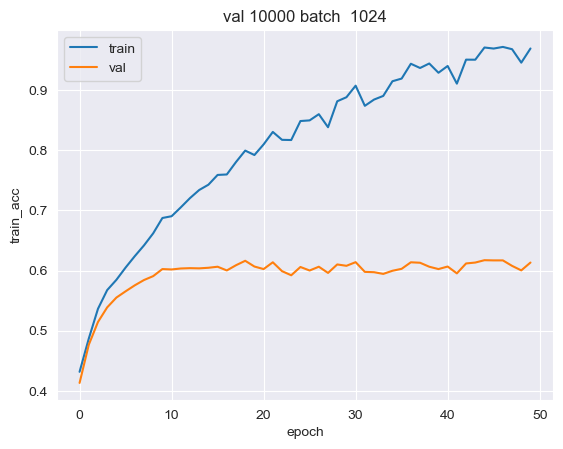

In [15]:
val_size = 10000
batch_size = 1024

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [],
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

# Milestones

Loss 20.835: 100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


val_acc: 0.643 train_acc: 0.939


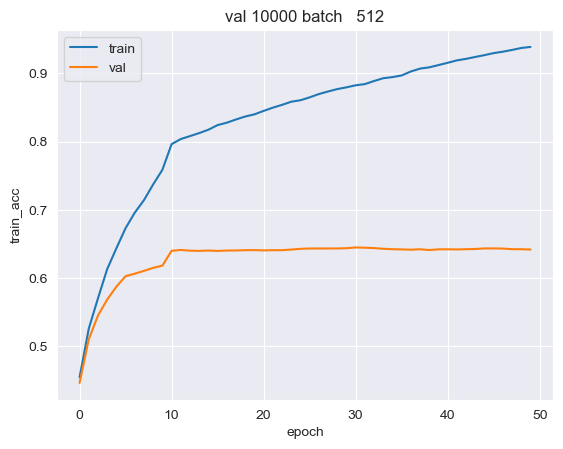

In [21]:
val_size = 10000
batch_size = 512

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [10],
    gamma=0.1,
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 10.944: 100%|██████████| 50/50 [00:26<00:00,  1.85it/s]


val_acc: 0.625 train_acc: 0.964


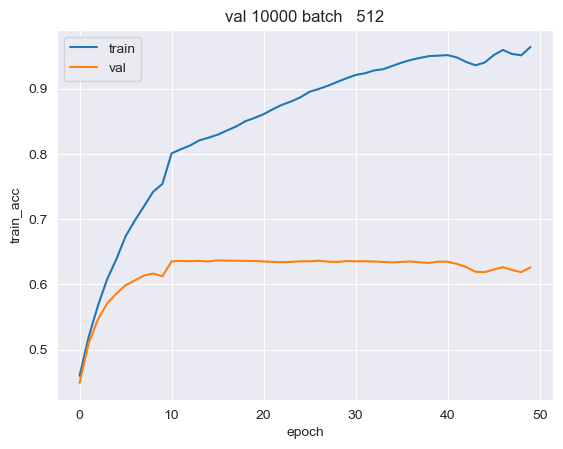

In [31]:
val_size = 10000
batch_size = 512

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [10],
    gamma=0.2,
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 1.619: 100%|██████████| 50/50 [00:27<00:00,  1.83it/s] 


val_acc: 0.641 train_acc: 0.999


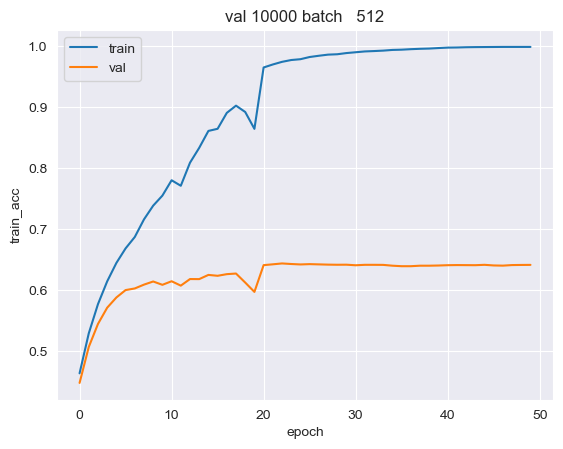

In [34]:
val_size = 10000
batch_size = 512

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [20],
    gamma=0.2,
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 3.786: 100%|██████████| 50/50 [00:26<00:00,  1.88it/s] 


val_acc: 0.641 train_acc: 0.997


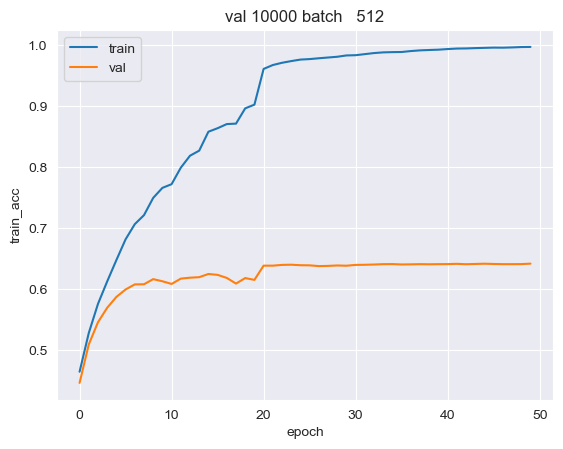

In [22]:
val_size = 10000
batch_size = 512

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [20],
    gamma=0.1,
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 0.998: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s] 


val_acc: 0.644 train_acc: 1.000


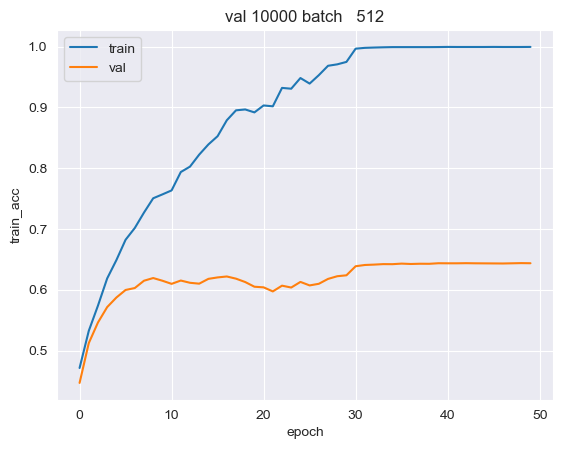

In [18]:
val_size = 10000
batch_size = 512

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [30],
    gamma=0.1,
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 0.375: 100%|██████████| 50/50 [00:27<00:00,  1.81it/s] 


val_acc: 0.635 train_acc: 0.999


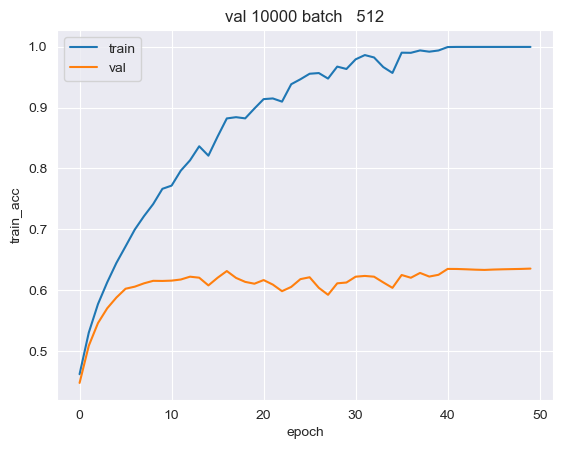

In [24]:
val_size = 10000
batch_size = 512

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [40],
    gamma=0.1,
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 1.381: 100%|██████████| 50/50 [00:27<00:00,  1.85it/s] 


val_acc: 0.638 train_acc: 0.995


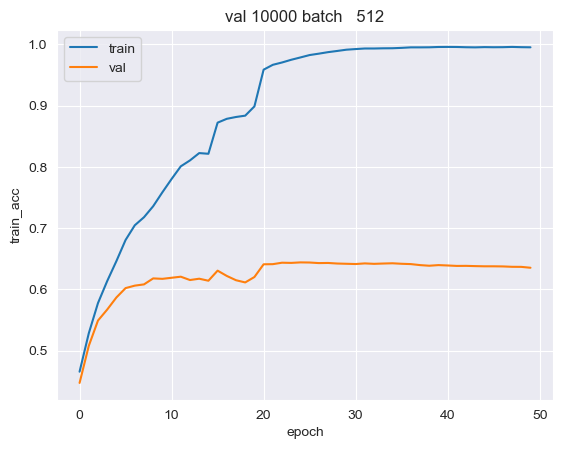

In [25]:
val_size = 10000
batch_size = 512

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [20],
    gamma=0.25,
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 0.712: 100%|██████████| 50/50 [00:27<00:00,  1.85it/s] 


val_acc: 0.629 train_acc: 0.997


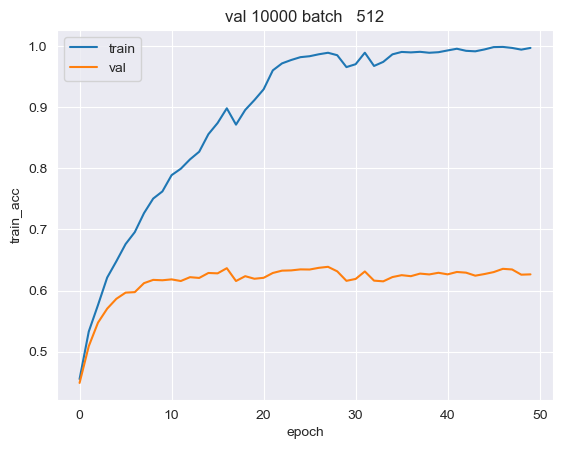

In [26]:
val_size = 10000
batch_size = 512

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [20],
    gamma=0.5,
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

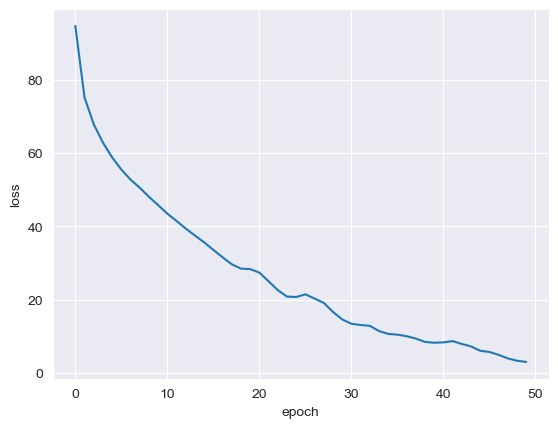

In [9]:
sns.lineplot(res, x = 'epoch', y = 'loss');

# Check different models

In [41]:
# df.sort_values(by='val_acc', ascending=False, inplace=True)
df.query("time < 120")

,hex_str,flops,macs,params,time,val_acc,train_acc,log_params,log_flops,log_time
310,0082009110080000002928000100000080004000100200...,12470656,6225408,5552554,13.457602,0.726562,0.918945,15.529769,16.338889,2.599544
77,0081021240000000200000000080208540000000080800...,24060928,11987968,7573450,68.260734,0.726562,0.990234,15.840159,16.996100,4.223335
359,0080208920000000400000000080282200254800100400...,55969408,27920640,913867,112.450689,0.719727,0.945312,13.725440,17.840316,4.722515
873,0080809240000000100200000042600040000000010000...,34535904,17193088,14211690,44.284568,0.715820,0.965820,16.469575,17.357510,3.790636
991,008020a2004290000022b0000808000040000000008204...,46229440,22873344,148011,84.155292,0.708984,0.794922,11.905042,17.649127,4.432664
...,...,...,...,...,...,...,...,...,...,...
451,008040860044a000002948004000000010080000008090...,2612672,1285632,82955,17.752853,0.201172,0.216797,11.326054,14.775884,2.876546
129,0080500608040000400000000028b00000449000001000...,448672,200704,181035,16.418530,0.192383,0.167969,12.106446,13.014047,2.798411
115,0082011210080000400000000023480000880061200000...,4776752,2363776,92251,29.879237,0.176758,0.184570,11.432268,15.379271,3.397164
408,0088010520000000400000000028c80000802805200000...,403224,199384,172922,15.385370,0.169922,0.196289,12.060596,12.907248,2.733417


Loss 0.232: 100%|██████████| 50/50 [00:28<00:00,  1.77it/s] 


val_acc: 0.635 train_acc: 0.999


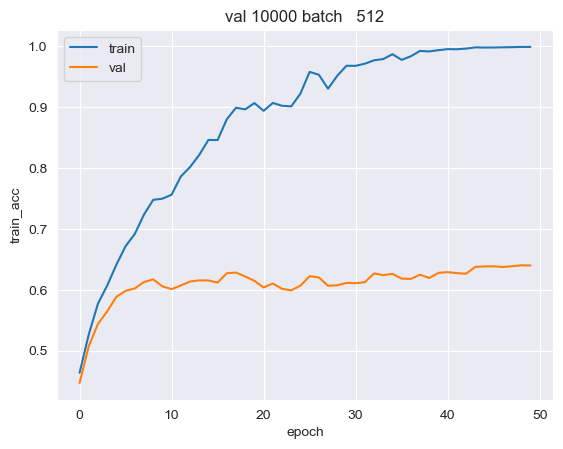

In [77]:
#310 []
t = encoder.hash2model(df.loc[310, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

val_size = 10000
batch_size = 512

res = train_on_gpu(
    model=model,
    loader=dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones=[],
    # gamma=0.1,
    num_epoch=50,
    verbose=True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 21.131: 100%|██████████| 50/50 [00:28<00:00,  1.73it/s]


val_acc: 0.641 train_acc: 0.938


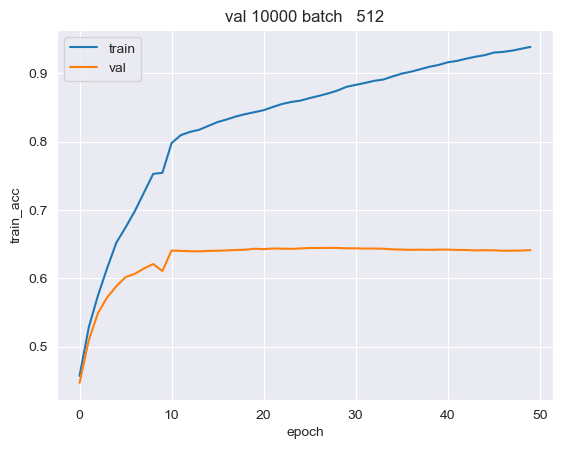

In [78]:
#310 [10] 0.1
t = encoder.hash2model(df.loc[310, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

val_size = 10000
batch_size = 512

res = train_on_gpu(
    model=model,
    loader=dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones=[10],
    gamma=0.1,
    num_epoch=50,
    verbose=True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 21.661: 100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


val_acc: 0.640 train_acc: 0.935


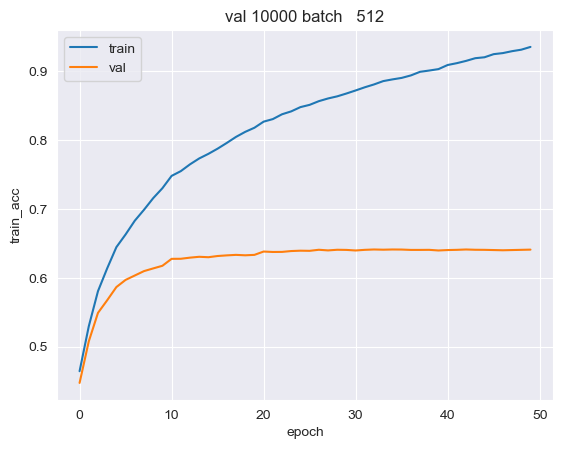

In [79]:
#310 [5 10 20] 0.5
t = encoder.hash2model(df.loc[310, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

val_size = 10000
batch_size = 512

res = train_on_gpu(
    model = model,
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [5, 10, 20],
    gamma=0.5,
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 26.760: 100%|██████████| 50/50 [00:27<00:00,  1.81it/s]


val_acc: 0.619 train_acc: 0.836


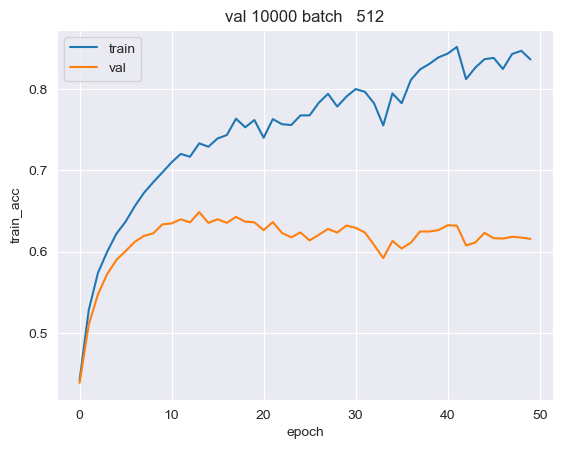

In [82]:
#116 []
t = encoder.hash2model(df.loc[116, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

val_size = 10000
batch_size = 512

res = train_on_gpu(
    model = model,
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [],
    gamma=0.5,
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 43.085: 100%|██████████| 50/50 [00:28<00:00,  1.76it/s]


val_acc: 0.668 train_acc: 0.816


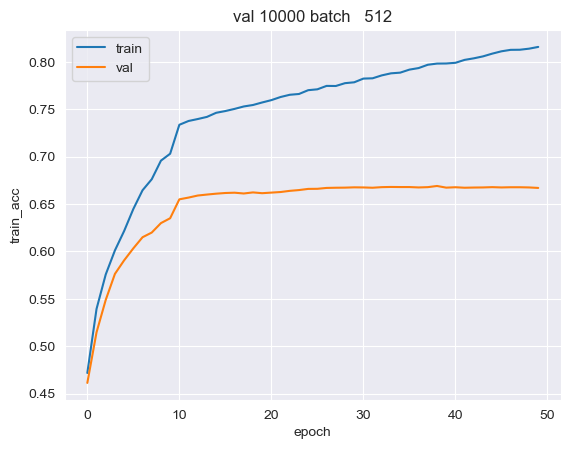

In [80]:
#116 [10] 0.1
t = encoder.hash2model(df.loc[116, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

val_size = 10000
batch_size = 512

res = train_on_gpu(
    model = model,
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [10],
    gamma=0.1,
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 43.543: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


val_acc: 0.668 train_acc: 0.805


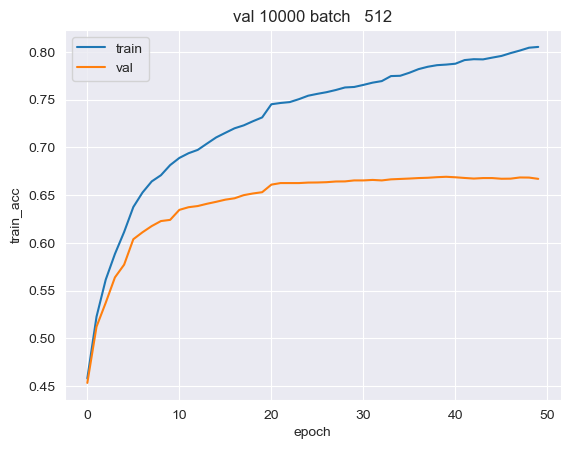

In [84]:
#116 [5, 10, 20] 0.5
t = encoder.hash2model(df.loc[116, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

val_size = 10000
batch_size = 512

res = train_on_gpu(
    model = model,
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [5, 10, 20],
    gamma=0.5,
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 0.962: 100%|██████████| 50/50 [00:23<00:00,  2.14it/s] 


val_acc: 0.686 train_acc: 0.991


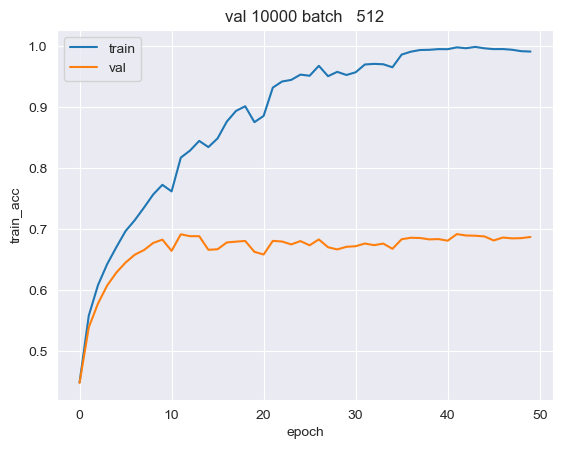

In [83]:
#279 [] 
t = encoder.hash2model(df.loc[279, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

val_size = 10000
batch_size = 512

res = train_on_gpu(
    model = model,
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [],
    gamma=0.1,
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 16.355: 100%|██████████| 50/50 [00:23<00:00,  2.12it/s]


val_acc: 0.705 train_acc: 0.948


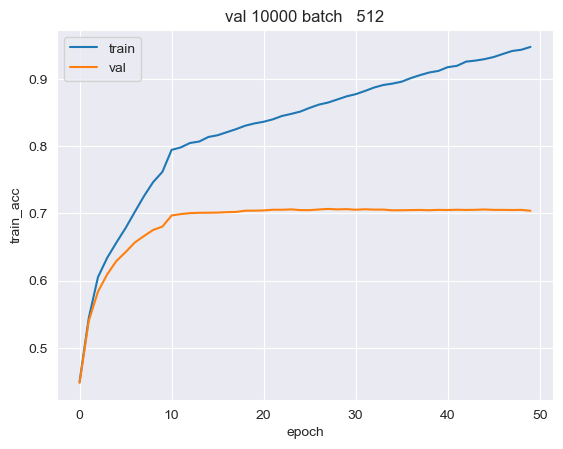

In [68]:
# 279 [10] 0.1
t = encoder.hash2model(df.loc[279, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

val_size = 10000
batch_size = 512

res = train_on_gpu(
    model = model,
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [10],
    gamma=0.1,
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 17.086: 100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


val_acc: 0.695 train_acc: 0.940


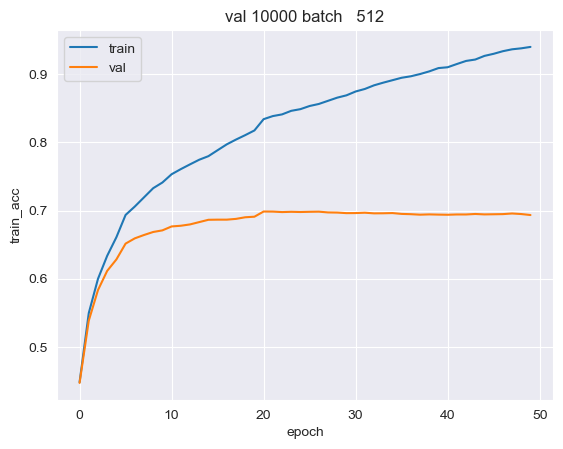

In [76]:
#279 [5 10 20] 0.5
t = encoder.hash2model(df.loc[279, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

val_size = 10000
batch_size = 512

res = train_on_gpu(
    model=model,
    loader=dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones=[5, 10, 20],
    gamma=0.5,
    num_epoch=50,
    verbose=True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 60.399: 100%|██████████| 50/50 [01:39<00:00,  1.99s/it]


val_acc: 0.682 train_acc: 0.729


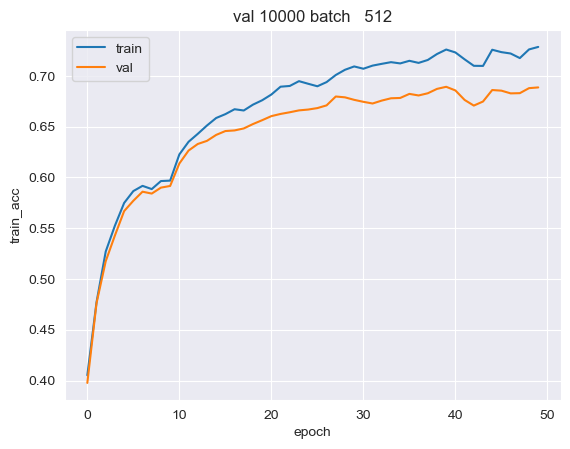

In [73]:
#890 []
t = encoder.hash2model(df.loc[890, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

val_size = 10000
batch_size = 512

res = train_on_gpu(
    model = model,
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [],
    gamma=0.1,
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 73.953: 100%|██████████| 50/50 [01:37<00:00,  1.96s/it]


val_acc: 0.647 train_acc: 0.668


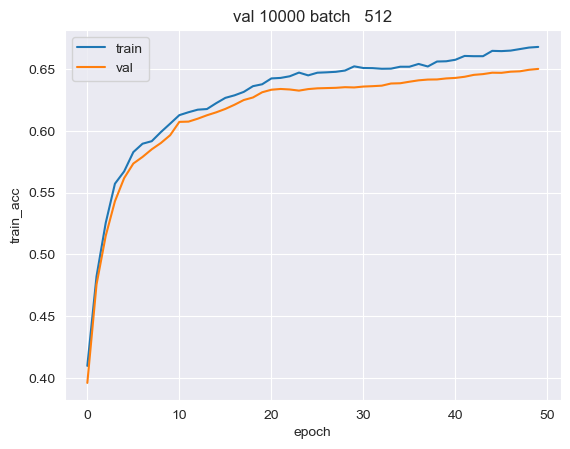

In [75]:
#890 [5 10 20] 0.5
t = encoder.hash2model(df.loc[890, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

val_size = 10000
batch_size = 512

res = train_on_gpu(
    model = model,
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [5, 10, 20],
    gamma=0.5,
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 74.326: 100%|██████████| 50/50 [01:39<00:00,  1.99s/it]


val_acc: 0.652 train_acc: 0.656


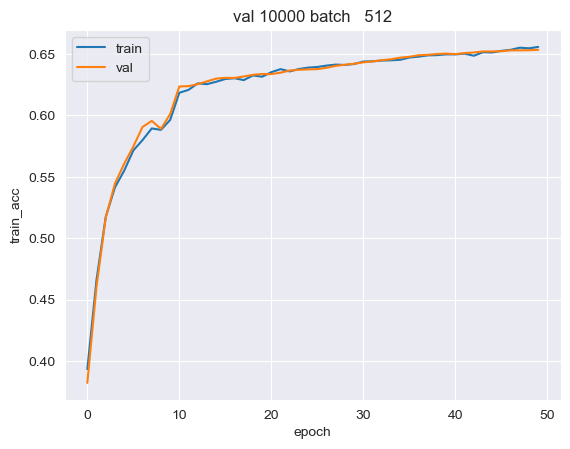

In [74]:
#890 [10] 0.1
t = encoder.hash2model(df.loc[890, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

val_size = 10000
batch_size = 512

res = train_on_gpu(
    model = model,
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [10],
    gamma=0.1,
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

# Schedulers

In [92]:
from sophius.train import train_on_gpu_ex
from torch.optim import AdamW
from torch.optim.lr_scheduler import ExponentialLR

df[['log_flops', 'time', 'val_acc', 'train_acc']].round(3)

,log_flops,time,val_acc,train_acc
930,20.684,613.818,0.813,0.994
302,19.434,258.427,0.787,0.977
23,17.706,177.062,0.756,0.996
763,19.176,282.492,0.753,0.878
310,16.339,13.458,0.727,0.919
...,...,...,...,...
208,16.894,164.906,0.195,0.284
129,13.014,16.419,0.192,0.168
115,15.379,29.879,0.177,0.185
408,12.907,15.385,0.170,0.196


Loss 0.285: 100%|██████████| 50/50 [00:28<00:00,  1.73it/s] 


val_acc: 0.630 train_acc: 0.998


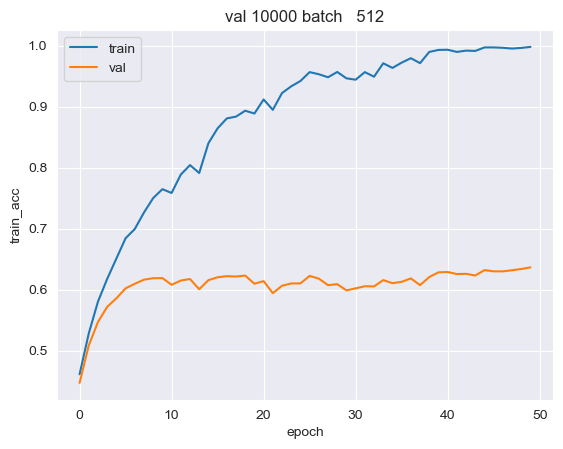

In [102]:
#310 base
t = encoder.hash2model(df.loc[310, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

val_size = 10000
batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=1)


res = train_on_gpu_ex(
    model = model,
    dataset=cifar_gpu,
    batch_size = batch_size,
    num_epoch = 50,
    verbose = True,
    optimizer=optimizer,
    scheduler=None,
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 0.507: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s] 


val_acc: 0.629 train_acc: 0.999


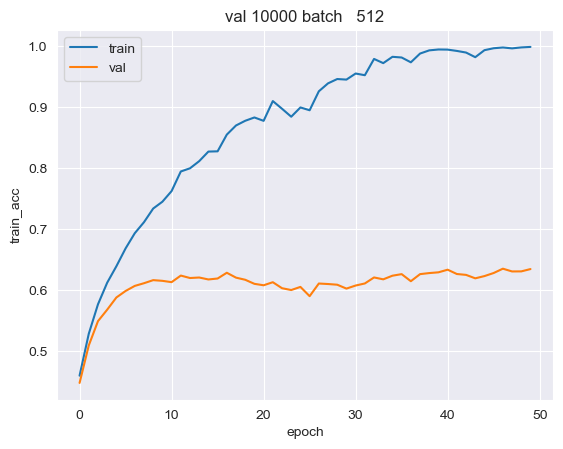

In [103]:
#310 exp 0.99
t = encoder.hash2model(df.loc[310, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.99)

res = train_on_gpu_ex(
    model = model,
    dataset=cifar_gpu,
    batch_size = batch_size,
    num_epoch = 50,
    verbose = True,
    optimizer=optimizer,
    scheduler=scheduler,
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'{res.val_acc[-10:].mean():.3f}');

Loss 10.062: 100%|██████████| 50/50 [00:28<00:00,  1.75it/s]


val_acc: 0.641 train_acc: 0.983


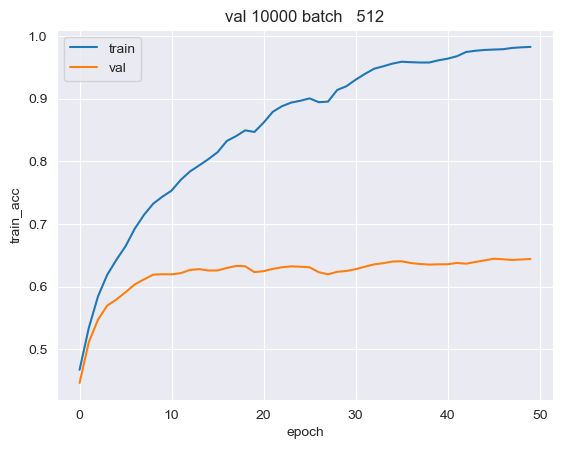

In [104]:
#310 exp 0.95
t = encoder.hash2model(df.loc[310, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.95)


res = train_on_gpu_ex(
    model = model,
    dataset=cifar_gpu,
    batch_size = batch_size,
    num_epoch = 50,
    verbose = True,
    optimizer=optimizer,
    scheduler=scheduler,
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 38.997: 100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


val_acc: 0.646 train_acc: 0.848


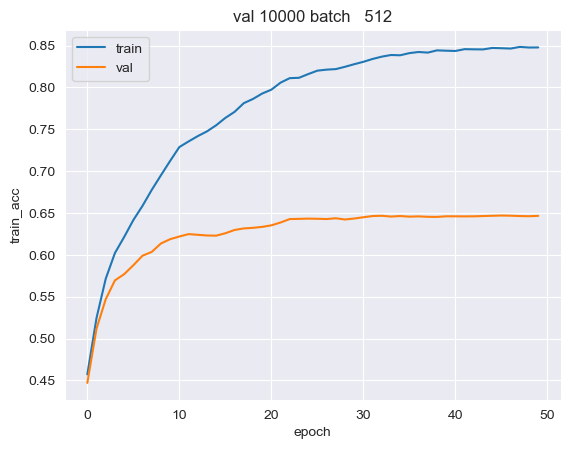

In [105]:
#310 exp 0.9
t = encoder.hash2model(df.loc[310, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.9)


res = train_on_gpu_ex(
    model = model,
    dataset=cifar_gpu,
    batch_size=batch_size,
    num_epoch = 50,
    verbose = True,
    optimizer=optimizer,
    scheduler=scheduler,
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');


Loss 0.006: 100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


val_acc: 0.665 train_acc: 0.999


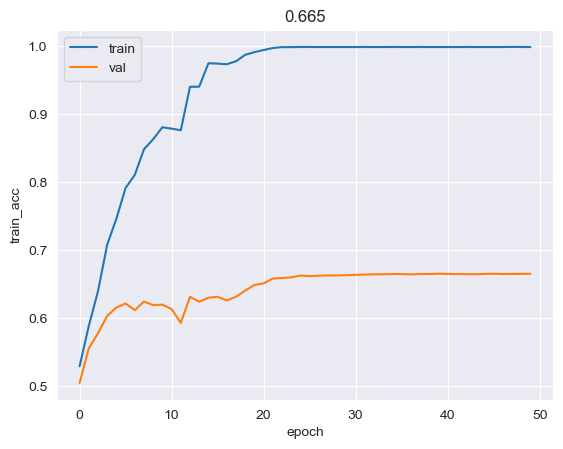

In [112]:
#77 base
t = encoder.hash2model(df.loc[77, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=1)

res = train_on_gpu_ex(
    model = model,
    dataset=cifar_gpu,
    batch_size=batch_size,
    num_epoch = 50,
    verbose = True,
    optimizer=optimizer,
    scheduler=scheduler,
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'{res.val_acc[-10:].mean():.3f}');


Loss 0.404: 100%|██████████| 50/50 [01:23<00:00,  1.68s/it]


val_acc: 0.662 train_acc: 0.999


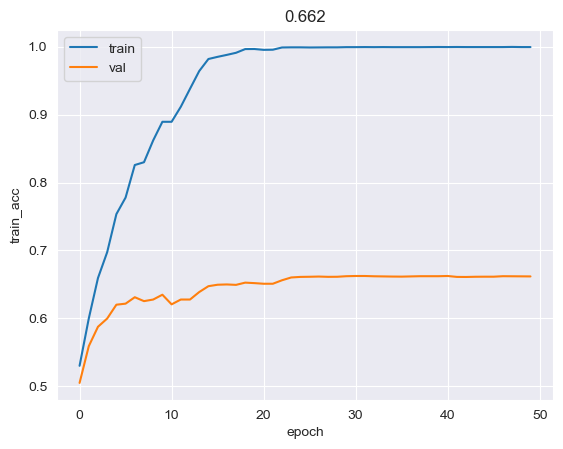

In [113]:
#77 0.9
t = encoder.hash2model(df.loc[77, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.9)

res = train_on_gpu_ex(
    model = model,
    dataset=cifar_gpu,
    batch_size=batch_size,
    num_epoch = 50,
    verbose = True,
    optimizer=optimizer,
    scheduler=scheduler,
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'{res.val_acc[-10:].mean():.3f}');

Loss 9.138: 100%|██████████| 50/50 [03:11<00:00,  3.83s/it] 


val_acc: 0.674 train_acc: 0.939


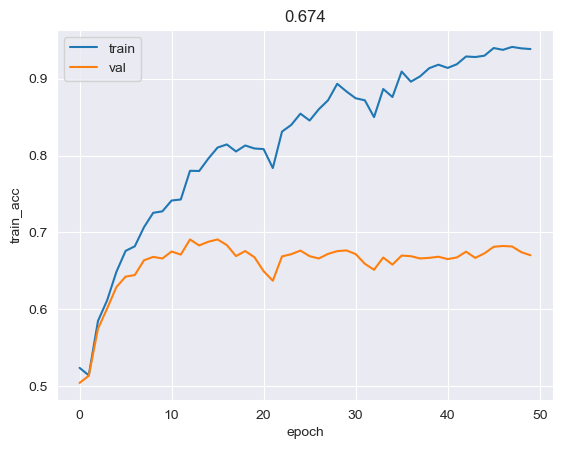

In [107]:
#359 base
t = encoder.hash2model(df.loc[359, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.9)

res = train_on_gpu_ex(
    model = model,
    dataset=cifar_gpu,
    batch_size=batch_size,
    num_epoch = 50,
    verbose = True,
    optimizer=optimizer,
    scheduler=None,
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'{res.val_acc[-10:].mean():.3f}');


Loss 3.588: 100%|██████████| 50/50 [03:08<00:00,  3.76s/it]


val_acc: 0.690 train_acc: 0.977


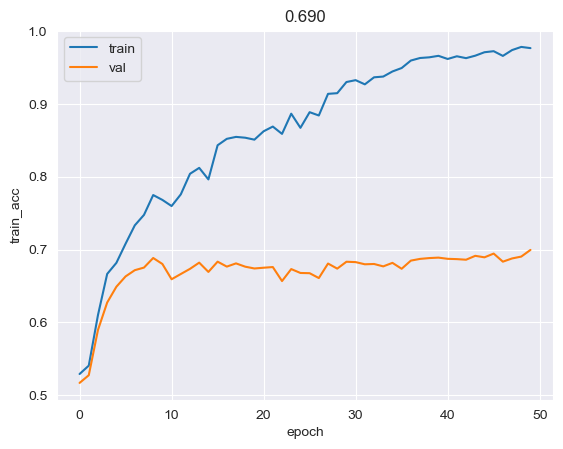

In [109]:
#359 exp 0.99
t = encoder.hash2model(df.loc[359, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.99)

res = train_on_gpu_ex(
    model = model,
    dataset=cifar_gpu,
    batch_size=batch_size,
    num_epoch = 50,
    verbose = True,
    optimizer=optimizer,
    scheduler=scheduler,
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'{res.val_acc[-10:].mean():.3f}');


Loss 1.179: 100%|██████████| 50/50 [03:09<00:00,  3.80s/it]


val_acc: 0.709 train_acc: 0.998


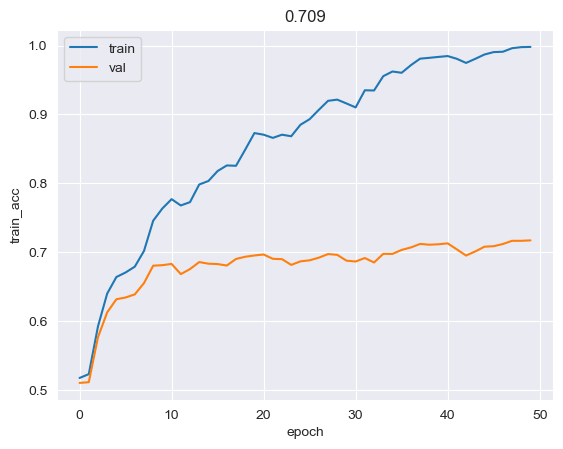

In [110]:
#359 exp 0.95
t = encoder.hash2model(df.loc[359, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.95)

res = train_on_gpu_ex(
    model = model,
    dataset=cifar_gpu,
    batch_size=batch_size,
    num_epoch = 50,
    verbose = True,
    optimizer=optimizer,
    scheduler=scheduler,
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'{res.val_acc[-10:].mean():.3f}');


Loss 11.065: 100%|██████████| 50/50 [03:10<00:00,  3.81s/it]


val_acc: 0.712 train_acc: 0.962


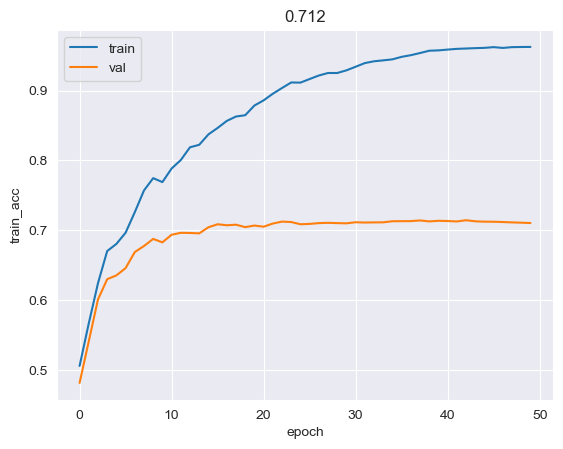

In [111]:
#359 exp 0.9
t = encoder.hash2model(df.loc[359, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.9)

res = train_on_gpu_ex(
    model = model,
    dataset=cifar_gpu,
    batch_size=batch_size,
    num_epoch = 50,
    verbose = True,
    optimizer=optimizer,
    scheduler=scheduler,
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'{res.val_acc[-10:].mean():.3f}');


Loss 4.125: 100%|██████████| 50/50 [09:05<00:00, 10.92s/it]


val_acc: 0.727 train_acc: 0.973


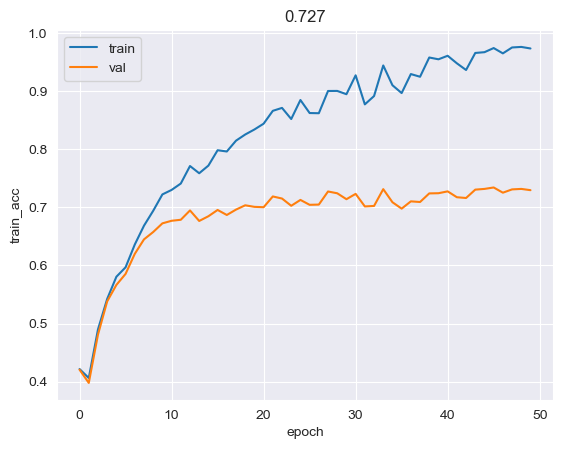

In [115]:
#302 base
t = encoder.hash2model(df.loc[302, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=1)

res = train_on_gpu_ex(
    model = model,
    dataset=cifar_gpu,
    batch_size=batch_size,
    num_epoch = 50,
    verbose = True,
    optimizer=optimizer,
    scheduler=scheduler,
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'{res.val_acc[-10:].mean():.3f}');


Loss 1.810: 100%|██████████| 50/50 [09:05<00:00, 10.92s/it]


val_acc: 0.714 train_acc: 0.996


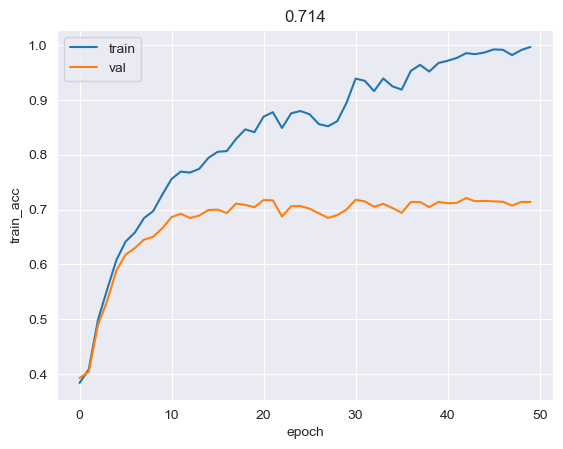

In [116]:
#302 exp 0.95
t = encoder.hash2model(df.loc[302, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.95)

res = train_on_gpu_ex(
    model = model,
    dataset=cifar_gpu,
    batch_size=batch_size,
    num_epoch = 50,
    verbose = True,
    optimizer=optimizer,
    scheduler=scheduler,
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'{res.val_acc[-10:].mean():.3f}');


Loss 6.838: 100%|██████████| 50/50 [03:12<00:00,  3.85s/it]


val_acc: 0.605 train_acc: 0.966


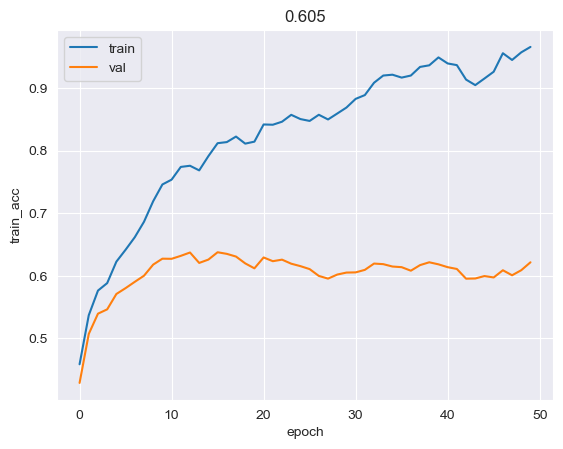

In [117]:
#27 base
t = encoder.hash2model(df.loc[27, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=1)

res = train_on_gpu_ex(
    model = model,
    dataset=cifar_gpu,
    batch_size=batch_size,
    num_epoch = 50,
    verbose = True,
    optimizer=optimizer,
    scheduler=scheduler,
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'{res.val_acc[-10:].mean():.3f}');


Loss 5.444: 100%|██████████| 50/50 [03:13<00:00,  3.87s/it]


val_acc: 0.612 train_acc: 0.971


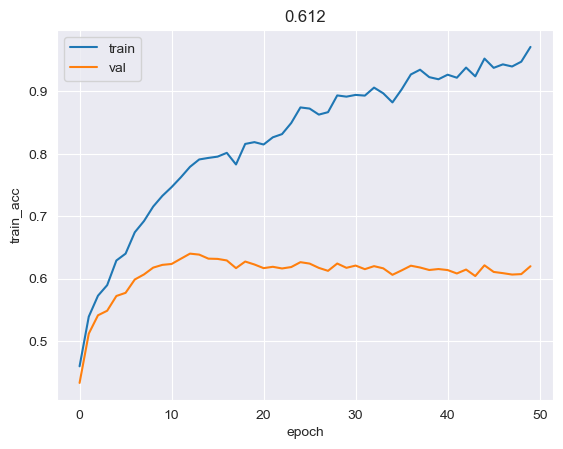

In [118]:
#27 exp 0.99
t = encoder.hash2model(df.loc[27, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.99)

res = train_on_gpu_ex(
    model = model,
    dataset=cifar_gpu,
    batch_size=batch_size,
    num_epoch = 50,
    verbose = True,
    optimizer=optimizer,
    scheduler=scheduler,
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'{res.val_acc[-10:].mean():.3f}');


Loss 18.938: 100%|██████████| 50/50 [03:11<00:00,  3.84s/it]


val_acc: 0.638 train_acc: 0.930


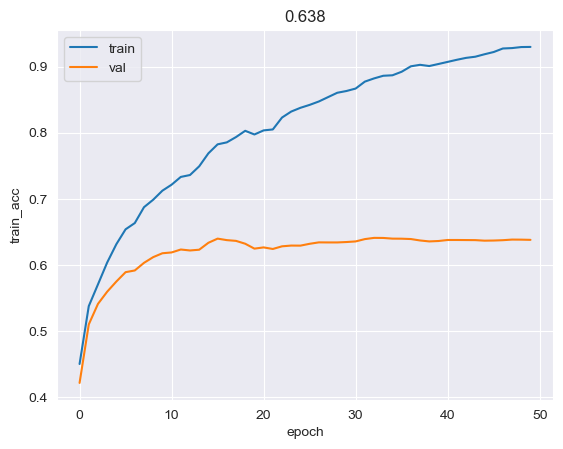

In [119]:
#27 exp 0.95
t = encoder.hash2model(df.loc[27, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.95)

res = train_on_gpu_ex(
    model = model,
    dataset=cifar_gpu,
    batch_size=batch_size,
    num_epoch = 50,
    verbose = True,
    optimizer=optimizer,
    scheduler=scheduler,
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'{res.val_acc[-10:].mean():.3f}');


Loss 2.447: 100%|██████████| 50/50 [18:23<00:00, 22.07s/it]


val_acc: 0.774 train_acc: 0.987


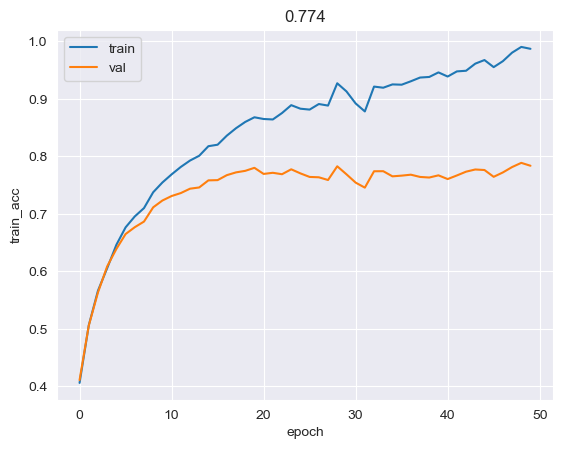

In [120]:
#930 base
t = encoder.hash2model(df.loc[930, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=1)

res = train_on_gpu_ex(
    model = model,
    dataset=cifar_gpu,
    batch_size=batch_size,
    num_epoch = 50,
    verbose = True,
    optimizer=optimizer,
    scheduler=scheduler,
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'{res.val_acc[-10:].mean():.3f}');


Loss 19.696: 100%|██████████| 50/50 [18:21<00:00, 22.03s/it]


val_acc: 0.779 train_acc: 0.919


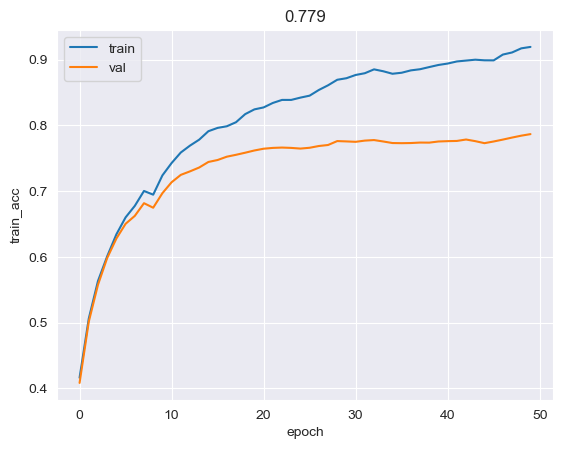

In [121]:
#930 exp 0.95
t = encoder.hash2model(df.loc[930, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)

batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.95)

res = train_on_gpu_ex(
    model = model,
    dataset=cifar_gpu,
    batch_size=batch_size,
    num_epoch = 50,
    verbose = True,
    optimizer=optimizer,
    scheduler=scheduler,
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'{res.val_acc[-10:].mean():.3f}');